## Method 2 Scenario discovery

### Step 1 Import the packages

In [8]:
# EMA workbench packages
from ema_workbench import Model, RealParameter, ScalarOutcome, Constant
from ema_workbench import Policy, perform_experiments
from ema_workbench import ema_logging, MultiprocessingEvaluator
ema_logging.log_to_stderr(ema_logging.INFO)
from ema_workbench import save_results
from ema_workbench import load_results

# Import a package to generate random numbers
import random

# Import PRIM package
import prim as prm

# A package to calculate duration of experiments
import time

# Basic packages for plotting and working with data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Step 2 Load the model

In [2]:
# Import the model as a function from .py file
from lakemodel_function import lake_problem

# Instantiate the model
lake_model = Model('lakeproblem', function=lake_problem)

# Specify the number of steps
lake_model.time_horizon = 100

### Step 3 Define levers, outcomes, uncertainties and policies

In [4]:
# Set levers, one for each time step
lake_model.levers = [RealParameter(str(i), 0, 0.1) for i in 
                     range(lake_model.time_horizon)] # we use time_horizon here

# Specify uncertainties
lake_model.uncertainties = [RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('delta', 0.93, 0.99)]

# Specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P'),
                       ScalarOutcome('utility'),
                       ScalarOutcome('inertia'),
                       ScalarOutcome('reliability')]

# Specify policies
policy_0 = Policy("No release", **{l.name:0 for l in lake_model.levers})
policy_quarter = Policy("Quarter release", **{l.name:random.randint(0, 25)/100 for l in lake_model.levers})
policy_half = Policy("Half release", **{l.name:random.randint(25, 50)/100 for l in lake_model.levers})
policy_max = Policy("Max release", **{l.name:random.randint(50, 100)/100 for l in lake_model.levers})

### Step 4 Perform Experiments

In [5]:
start = time.time()
n_scenarios = 5000
results = perform_experiments(lake_model, n_scenarios, [policy_0,policy_quarter,policy_half,policy_max])
end = time.time()
print('The algorithm time is:',(end - start)/60, 'minutes')

[MainProcess/INFO] performing 5000 scenarios * 4 policies * 1 model(s) = 20000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] 12000 cases completed
[MainProcess/INFO] 14000 cases completed
[MainProcess/INFO] 16000 cases completed
[MainProcess/INFO] 18000 cases completed
[MainProcess/INFO] 20000 cases completed
[MainProcess/INFO] experiments finished


The algorithm time is: 8.859676186243693 minutes


In [9]:
# Save results
file_name = 'results_for_sd.tar.gz'
save_results(results, file_name)
results = load_results(file_name)

[MainProcess/INFO] results saved successfully to C:\Users\Mikhail\Documents\GitHub\sd_summer_school\results_for_sd.tar.gz
[MainProcess/INFO] results loaded succesfully from C:\Users\Mikhail\Documents\GitHub\sd_summer_school\results_for_sd.tar.gz


In [10]:
# Load results
results = load_results('results_for_sd.tar.gz')

[MainProcess/INFO] results loaded succesfully from C:\Users\Mikhail\Documents\GitHub\sd_summer_school\results_for_sd.tar.gz


### Step 5 Run the method

#### Preprocess the data

In [11]:
# Get the results
experiments, outcomes = results
df_experiment = pd.DataFrame(experiments)
df_output = pd.DataFrame(outcomes)

# Select the policies to evaluate
select_policy_0 = (df_experiment.policy == 'No release')
select_policy_quarter = (df_experiment.policy == 'Quarter release')
select_policy_half = (df_experiment.policy == 'Half release')
select_policy_max = (df_experiment.policy == 'Max release')

# Select a policy to do PRIM on it
x_prim_0 = df_experiment[select_policy_0].drop(['scenario_id','policy','model'],axis=1).to_records(index=False)
y_prim_0 = (df_output[select_policy_0]['max_P'] > 
              df_output[select_policy_0]['max_P'].mean()).astype(int).reset_index(drop=True)

#### PRIM 

In [12]:
prim_alg_0 = prm.Prim(x_prim_0, y_prim_0, threshold=0.8 ,threshold_type=">")
box1_0 = prim_alg_0.find_box()

C:\Users\Mikhail\Anaconda3\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


### Step 6 Visualize results

#### Decide on the tradeoff between coverage and density

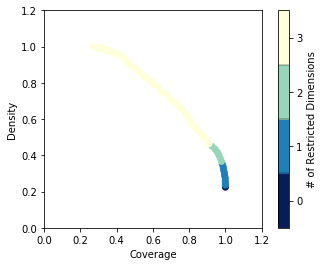

In [15]:
# %matplotlib notebook
%matplotlib inline
box1_0.show_tradeoff()
plt.show()

#### Choose a box

C:\Users\Mikhail\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


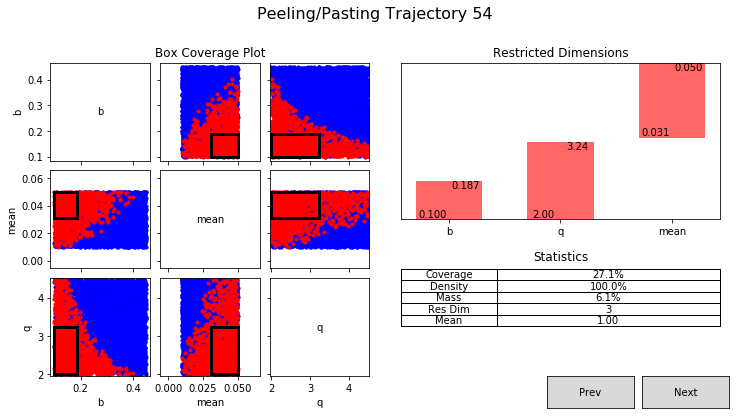

In [16]:
box_selection = 54
box1_0.select(box_selection)
box1_0.show_details()
plt.show()